# AI Agronomist: Plant Disease Detection

## Setup and Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from sklearn.model_selection import train_test_split 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
data_dir = './data/plantvillage dataset/color'

## EDA

### Dataset Overview & Structure

In [3]:
import os

folders = [
    f for f in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, f))
]

print("Total class folders:", len(folders))
print("Sample folders:", folders[:5])

Total class folders: 38
Sample folders: ['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']


In [4]:
total_images = 0

for fold in folders:
    folder_path = os.path.join(data_dir, fold)
    total_images += len([
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    ])

print("Total images in dataset:", total_images)

Total images in dataset: 54305


In [5]:
# rows = []

# for fold in os.listdir(data_dir):
#     folder_path = os.path.join(data_dir, fold)
#     if not os.path.isdir(folder_path):
#         continue

#     plant, disease = fold.split("___")
#     num_images = len([
#         f for f in os.listdir(folder_path)
#         if os.path.isfile(os.path.join(folder_path, f))
#     ])

#     rows.append({
#         "plant": plant,
#         "disease": disease,
#         "num_images": num_images
#     })

# df = pd.DataFrame(rows)
# df.sort_values("num_images", ascending=False)

rows = []

for fold in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, fold)
    if not os.path.isdir(folder_path):
        continue

    if "___" not in fold:
        continue

    plant, disease = fold.split("___")

    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        if not os.path.isfile(img_path):
            continue

        rows.append({
            "image_path": img_path,
            "plant": plant,
            "disease": disease,
            "class": fold
        })

df= pd.DataFrame(rows)
print(df.head())


                                          image_path       plant  disease  \
0  ./data/plantvillage dataset/color/Strawberry__...  Strawberry  healthy   
1  ./data/plantvillage dataset/color/Strawberry__...  Strawberry  healthy   
2  ./data/plantvillage dataset/color/Strawberry__...  Strawberry  healthy   
3  ./data/plantvillage dataset/color/Strawberry__...  Strawberry  healthy   
4  ./data/plantvillage dataset/color/Strawberry__...  Strawberry  healthy   

                  class  
0  Strawberry___healthy  
1  Strawberry___healthy  
2  Strawberry___healthy  
3  Strawberry___healthy  
4  Strawberry___healthy  


### Class Balance & Representation


In this part we:

- analyze class balance

- identify over-represented / under-represented classes

- look at the distribution:

- - plant + disease

- - separate plant

- - separate disease

- - make ML inferences (imbalanced dataset or not)

**disease by number of images. TOP-10 classes by number of images**

In [6]:
rows = []

for fold in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, fold)
    if not os.path.isdir(folder_path):
        continue

    plant, disease = fold.split("___")
    num_images = len([
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    ])

    rows.append({
        "plant": plant,
        "disease": disease,
        "num_images": num_images
    })

df_images = pd.DataFrame(rows)
df_images.sort_values("num_images", ascending=False)

,plant,disease,num_images
11,Orange,Haunglongbing_(Citrus_greening),5507
24,Tomato,Tomato_Yellow_Leaf_Curl_Virus,5357
37,Soybean,healthy,5090
28,Peach,Bacterial_spot,2297
16,Tomato,Bacterial_spot,2127
8,Tomato,Late_blight,1909
31,Squash,Powdery_mildew,1835
30,Tomato,Septoria_leaf_spot,1771
27,Tomato,Spider_mites Two-spotted_spider_mite,1676
34,Apple,healthy,1645


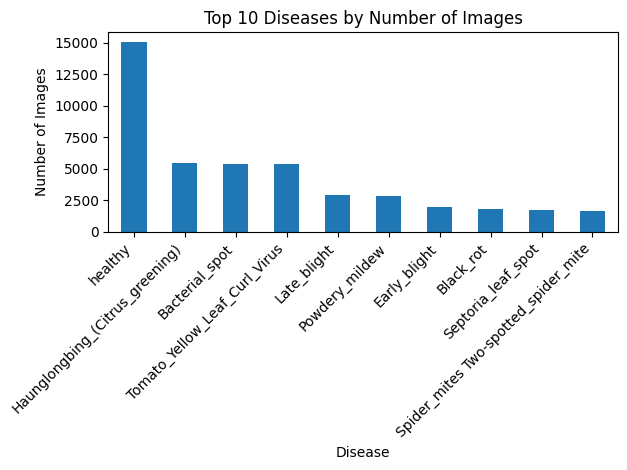

In [7]:
import matplotlib.pyplot as plt

disease_sum = (
    df_images.groupby("disease")["num_images"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
disease_sum.head(10).plot(kind="bar")
plt.title("Top 10 Diseases by Number of Images")
plt.xlabel("Disease")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Distribution of images by plants**

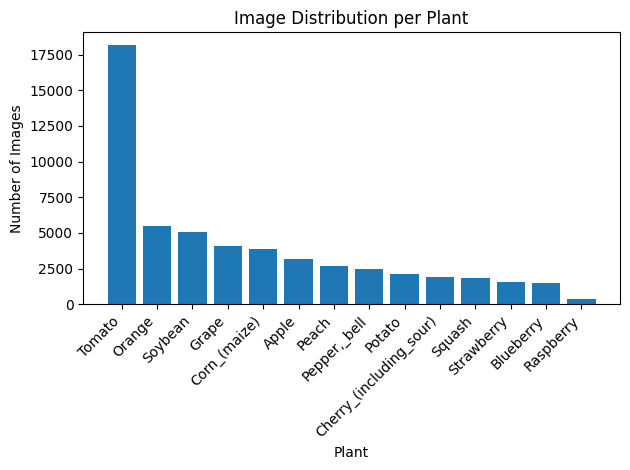

In [8]:
plant_distribution = (
    df_images.groupby("plant")["num_images"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(plant_distribution.index, plant_distribution.values)
plt.title("Image Distribution per Plant")
plt.xlabel("Plant")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Plans for disease**

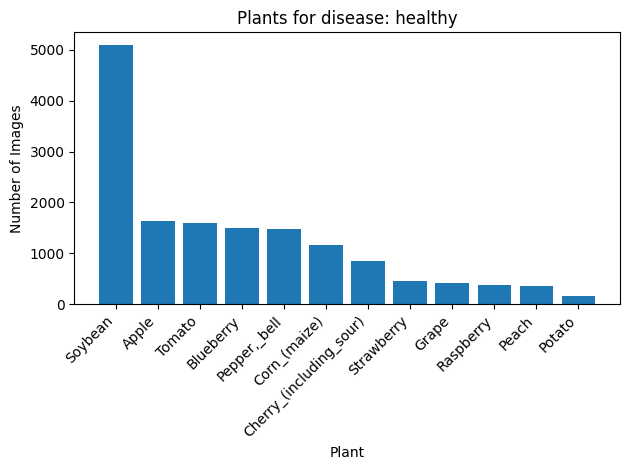

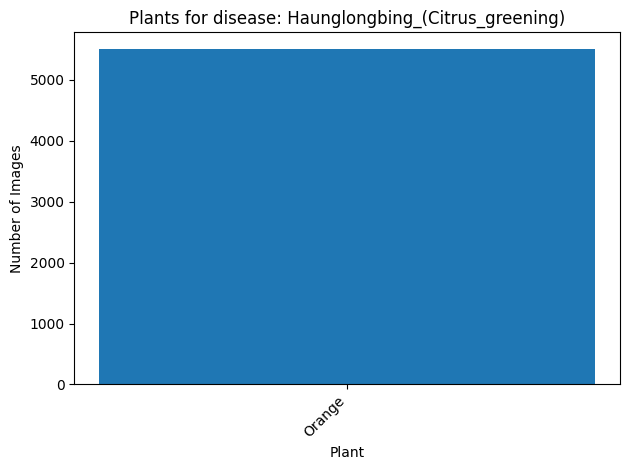

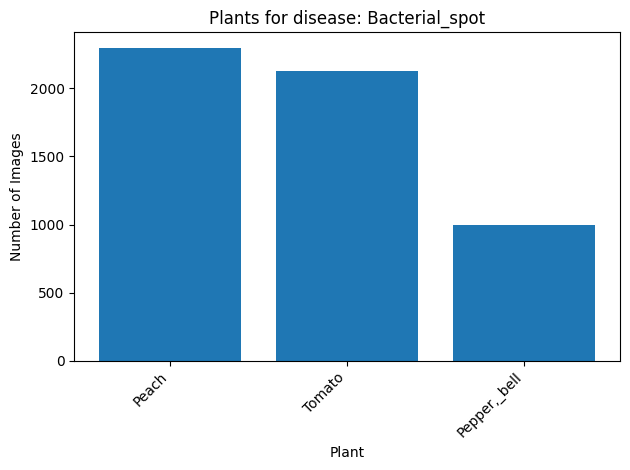

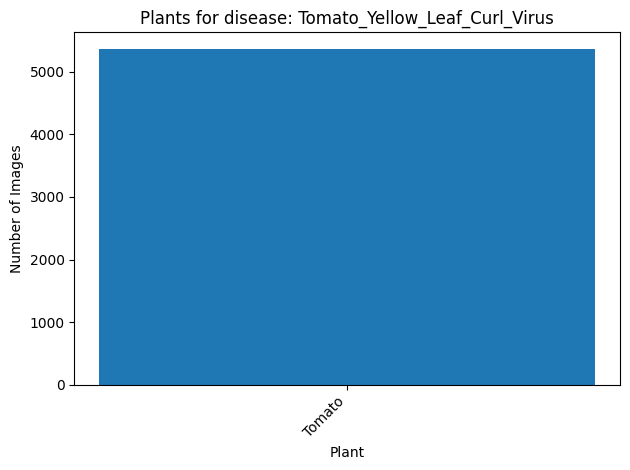

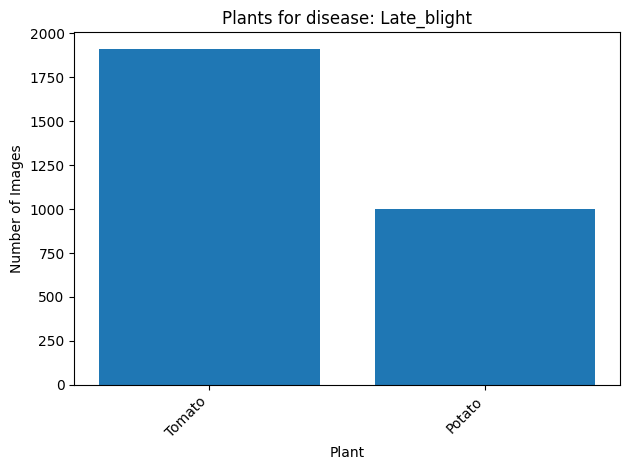

In [9]:
top_disease = disease_sum.head(5).index

for disease in top_disease:
    subset = df_images[df_images["disease"] == disease].sort_values(
        "num_images", ascending=False
    )

    plt.figure()
    plt.bar(subset["plant"], subset["num_images"])
    plt.title(f"Plants for disease: {disease}")
    plt.xlabel("Plant")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

### Image Resolution & Aspect Ratio Analysis

In [10]:
from PIL import Image
import os

unique_sizes = set()

for fold in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, fold)
    if not os.path.isdir(folder_path):
        continue

    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        if not os.path.isfile(img_path):
            continue

        with Image.open(img_path) as im:
            unique_sizes.add(im.size)


In [11]:
print("Unique image sizes found:", unique_sizes)
print("Number of unique sizes:", len(unique_sizes))


Unique image sizes found: {(256, 256)}
Number of unique sizes: 1


### Color Space & Channel Validation

In [12]:
from PIL import Image
import os
from collections import Counter

color_modes = Counter()

for fold in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, fold)
    if not os.path.isdir(folder_path):
        continue

    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        if not os.path.isfile(img_path):
            continue

        try:
            with Image.open(img_path) as im:
                color_modes[im.mode] += 1
        except Exception as e:
            print("Error reading image:", img_path)


In [13]:
color_modes


Counter({'RGB': 54304, 'RGBA': 1})

54304 images — normal, RGB (3 channels)

1 image — RGBA (4 channels, with alpha channel)

Lets convert one image to 3 channels

In [14]:
from PIL import Image

def load_image_rgb(path):
    with Image.open(path) as img:
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img.copy()

In [15]:
for fold in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, fold)
    if not os.path.isdir(folder_path):
        continue

    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        if not os.path.isfile(img_path):
            continue

        try:
            load_image_rgb(img_path)
        except Exception as e:
            print("Error reading image:", img_path)


In [ ]:
import random
import matplotlib.pyplot as plt

sample_df = df.sample(9, random_state=42)


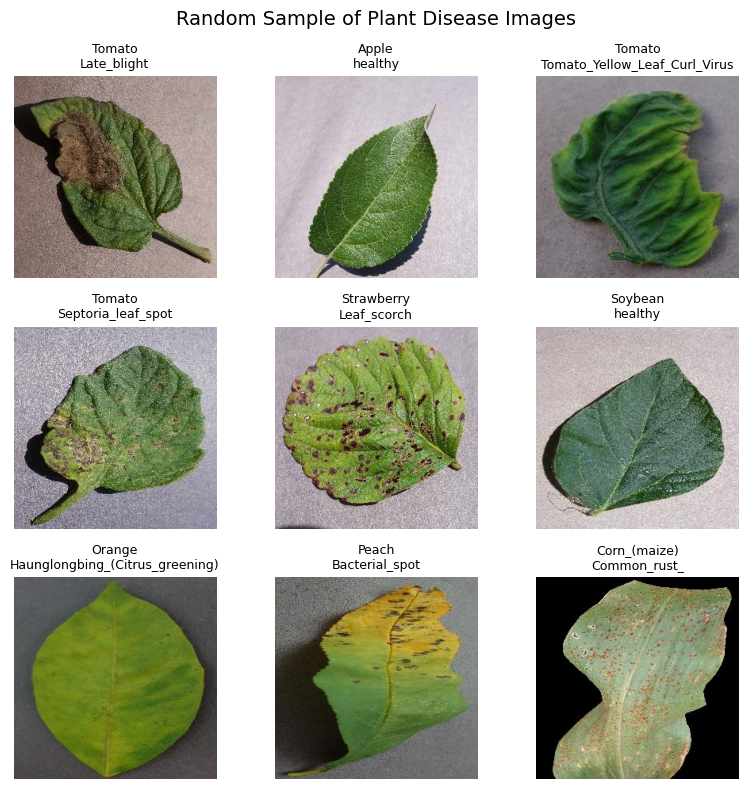

In [17]:
plt.figure(figsize=(8, 8))

for i, row in enumerate(sample_df.itertuples()):
    img = load_image_rgb(row.image_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row.plant}\n{row.disease}", fontsize=9)
    plt.axis("off")

plt.suptitle("Random Sample of Plant Disease Images", fontsize=14)
plt.tight_layout()
plt.show()


## Data Splitting & Model Training

In [ ]:
train_data, temp_data = train_test_split(
    df, 
    test_size=0.2, 
    shuffle=True, 
    stratify=df['class'], 
    random_state=42
)

valid_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    shuffle=True, 
    stratify=temp_data['class'], 
    random_state=42
)

print(f"Training set: {len(train_data)} images ({len(train_data)/len(df)*100:.1f}%)")
print(f"Validation set: {len(valid_data)} images ({len(valid_data)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_data)} images ({len(test_data)/len(df)*100:.1f}%)")
print(f"\nTotal classes in each set:")
print(f"  Train: {len(train_data['class'].unique())} classes")
print(f"  Valid: {len(valid_data['class'].unique())} classes")
print(f"  Test: {len(test_data['class'].unique())} classes")

Training set: 43444 images (80.0%)
Validation set: 5430 images (10.0%)
Test set: 5431 images (10.0%)

Total classes in each set:
  Train: 38 classes
  Valid: 38 classes
  Test: 38 classes


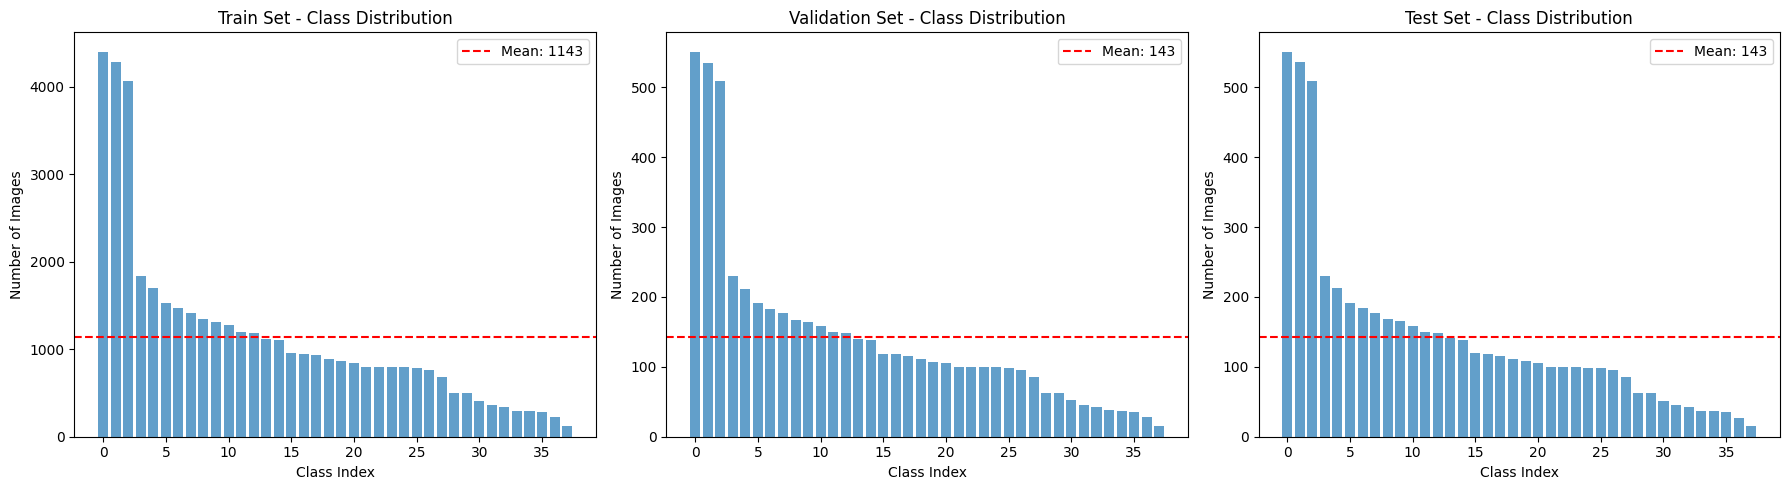


Class distribution statistics:
Train: min=122, max=4405, mean=1143.3, std=1017.4
Validation: min=15, max=551, mean=142.9, std=127.1
Test: min=15, max=551, mean=142.9, std=127.3


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, data) in zip(axes, [('Train', train_data), ('Validation', valid_data), ('Test', test_data)]):
    class_counts = data['class'].value_counts()
    ax.bar(range(len(class_counts)), class_counts.values, alpha=0.7)
    ax.set_title(f'{name} Set - Class Distribution')
    ax.set_xlabel('Class Index')
    ax.set_ylabel('Number of Images')
    ax.axhline(y=class_counts.mean(), color='r', linestyle='--', label=f'Mean: {class_counts.mean():.0f}')
    ax.legend()

plt.tight_layout()
plt.show()


print("\nClass distribution statistics:")
for name, data in [('Train', train_data), ('Validation', valid_data), ('Test', test_data)]:
    counts = data['class'].value_counts()
    print(f"{name}: min={counts.min()}, max={counts.max()}, mean={counts.mean():.1f}, std={counts.std():.1f}")

In [20]:
image_size = 224
batch_size = 32 
channel = 3 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='class',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(image_size, image_size),
    shuffle=True
)

num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

Found 43444 validated image filenames belonging to 38 classes.
Number of classes: 38


In [23]:
valid_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='image_path',
    y_col='class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 5430 validated image filenames belonging to 38 classes.


In [24]:
test_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 5431 validated image filenames belonging to 38 classes.


In [ ]:
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_xception_model(num_classes, input_shape=(224, 224, 3)):
    
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Create Xception
xception_model, xception_base = build_xception_model(num_classes)
xception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Xception Model Summary:")
print(f"Total parameters: {xception_model.count_params():,}")
#print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in xception_model.trainable_weights]):,}")


Xception Model Summary:
Total parameters: 22,061,902


In [ ]:
import tensorflow as tf

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_xception_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# training modелі Xception (Phase 1: Feature Extraction)
print("=" * 60)
print("Training Xception - Phase 1: Feature Extraction")
print("=" * 60)

EPOCHS_PHASE1 = 10

xception_history = xception_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)


Training Xception - Phase 1: Feature Extraction
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5825 - loss: 1.4921
Epoch 1: val_accuracy improved from None to 0.85709, saving model to best_xception_model.keras

Epoch 1: finished saving model to best_xception_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 933s 685ms/step - accuracy: 0.6748 - loss: 1.0951 - val_accuracy: 0.8571 - val_loss: 0.4598 - learning_rate: 0.0010
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7611 - loss: 0.7583
Epoch 2: val_accuracy improved from 0.85709 to 0.87035, saving model to best_xception_model.keras

Epoch 2: finished saving model to best_xception_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 935s 688ms/step - accuracy: 0.7712 - loss: 0.7233 - val_accuracy: 0.8703 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7886 - loss: 0.6675
Epoch 3: val_accuracy improved from 0.87035 to 0.87993, saving model to b

In [ ]:
# Phase 2: Fine-tuning - unfreeze last layers of base model
print("=" * 60)
print("Training Xception - Phase 2: Fine-tuning")
print("=" * 60)

#  unfreeze last 30 layers
xception_base.trainable = True
for layer in xception_base.layers[:-30]:
    layer.trainable = False

# recompile the model with a lower learning rate
xception_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in xception_model.trainable_weights]):,}")

# Fine-tuning callbacks
fine_tune_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_xception_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

EPOCHS_PHASE2 = 10

xception_history_ft = xception_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE2,
    callbacks=fine_tune_callbacks,
    verbose=1
)


Training Xception - Phase 2: Fine-tuning
Trainable parameters after unfreezing: 10,135,654
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9363 - loss: 0.1923
Epoch 1: val_accuracy improved from None to 0.96519, saving model to best_xception_finetuned.keras

Epoch 1: finished saving model to best_xception_finetuned.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1386s 1s/step - accuracy: 0.9376 - loss: 0.1894 - val_accuracy: 0.9652 - val_loss: 0.1026 - learning_rate: 1.0000e-05
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.9440 - loss: 0.1709
Epoch 2: val_accuracy improved from 0.96519 to 0.96851, saving model to best_xception_finetuned.keras

Epoch 2: finished saving model to best_xception_finetuned.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1355s 998ms/step - accuracy: 0.9431 - loss: 0.1728 - val_accuracy: 0.9685 - val_loss: 0.0935 - learning_rate: 1.0000e-05
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9429 - loss: 0.1681
Epoch 3

## Model 2: MobileNetV2

MobileNetV2 is a lightweight and efficient model optimized for mobile devices. It uses inverted residuals and linear bottlenecks. It is faster than Xception, but may have lower accuracy on complex problems.


In [ ]:
def build_mobilenet_model(num_classes, input_shape=(224, 224, 3)):
    
    # upload pre-trained model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # freeze base model layers
    base_model.trainable = False
    
    # add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Create MobileNetV2 model
mobilenet_model, mobilenet_base = build_mobilenet_model(num_classes)
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Model Summary:")
print(f"Total parameters: {mobilenet_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in mobilenet_model.trainable_weights]):,}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MobileNetV2 Model Summary:
Total parameters: 3,062,118
Trainable parameters: 800,550


In [ ]:
# Callbacks for MobileNetV2
mobilenet_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenet_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training MobileNetV2 (Phase 1: Feature Extraction)
print("=" * 60)
print("Training MobileNetV2 - Phase 1: Feature Extraction")
print("=" * 60)

mobilenet_history = mobilenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=mobilenet_callbacks,
    verbose=1
)


Training MobileNetV2 - Phase 1: Feature Extraction
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6596 - loss: 1.2193
Epoch 1: val_accuracy improved from None to 0.89595, saving model to best_mobilenet_model.keras

Epoch 1: finished saving model to best_mobilenet_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 240s 175ms/step - accuracy: 0.7547 - loss: 0.8196 - val_accuracy: 0.8959 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8326 - loss: 0.5320
Epoch 2: val_accuracy improved from 0.89595 to 0.90295, saving model to best_mobilenet_model.keras

Epoch 2: finished saving model to best_mobilenet_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 235s 173ms/step - accuracy: 0.8355 - loss: 0.5192 - val_accuracy: 0.9029 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8509 - loss: 0.4684
Epoch 3: val_accuracy improved from 0.90295 to 0.91510, saving mod

In [ ]:
# Phase 2: Fine-tuning for MobileNetV2
print("=" * 60)
print("Training MobileNetV2 - Phase 2: Fine-tuning")
print("=" * 60)

# unfreeze last 50 layers
mobilenet_base.trainable = True
for layer in mobilenet_base.layers[:-50]:
    layer.trainable = False

# recompile the model with a lower learning rate
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in mobilenet_model.trainable_weights]):,}")

# Fine-tuning callbacks
mobilenet_ft_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenet_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

mobilenet_history_ft = mobilenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE2,
    callbacks=mobilenet_ft_callbacks,
    verbose=1
)


Training MobileNetV2 - Phase 2: Fine-tuning
Trainable parameters after unfreezing: 2,655,654
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7854 - loss: 0.7451
Epoch 1: val_accuracy improved from None to 0.93131, saving model to best_mobilenet_finetuned.keras

Epoch 1: finished saving model to best_mobilenet_finetuned.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 334s 242ms/step - accuracy: 0.8222 - loss: 0.5954 - val_accuracy: 0.9313 - val_loss: 0.1979 - learning_rate: 1.0000e-05
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8713 - loss: 0.4180
Epoch 2: val_accuracy improved from 0.93131 to 0.94825, saving model to best_mobilenet_finetuned.keras

Epoch 2: finished saving model to best_mobilenet_finetuned.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 336s 247ms/step - accuracy: 0.8796 - loss: 0.3867 - val_accuracy: 0.9483 - val_loss: 0.1570 - learning_rate: 1.0000e-05
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8937 - loss: 0.3316


## Training Results Visualization

Порівняння кривих навчання (learning curves) для обох моделей - це ключовий етап для оцінки якості тренування та виявлення проблем, таких як overfitting чи underfitting.


In [3]:
def combine_histories(history1, history2):
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key]
    return combined

# Combine histories for both models
xception_full_history = combine_histories(xception_history, xception_history_ft)
mobilenet_full_history = combine_histories(mobilenet_history, mobilenet_history_ft)


NameError: name 'xception_history' is not defined

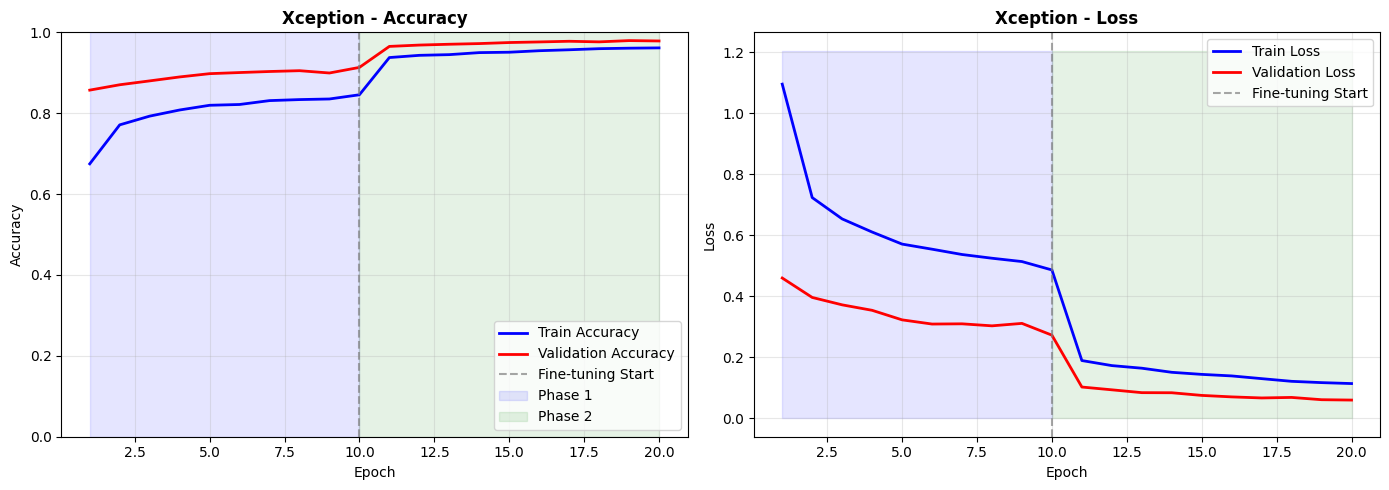


Xception Training Statistics:
--------------------------------------------------
Phase 1 (Feature Extraction):
  Final Train Acc: 0.8456
  Final Val Acc: 0.9133
  Gap (overfitting indicator): -0.0677

Phase 2 (Fine-tuning):
  Best Train Acc: 0.9615
  Best Val Acc: 0.9796
  Final Train Acc: 0.9615
  Final Val Acc: 0.9786
  Gap (overfitting indicator): -0.0171


In [ ]:
def plot_training_history(history, model_name, phase1_epochs):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['accuracy']) + 1)
    
    # Accuracy Plot
    axes[0].plot(epochs, history['accuracy'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0].plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=phase1_epochs, color='gray', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    axes[0].fill_between(range(1, phase1_epochs + 1), 0, 1, alpha=0.1, color='blue', label='Phase 1')
    axes[0].fill_between(range(phase1_epochs, len(epochs) + 1), 0, 1, alpha=0.1, color='green', label='Phase 2')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Loss Plot
    axes[1].plot(epochs, history['loss'], 'b-', label='Train Loss', linewidth=2)
    axes[1].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1].axvline(x=phase1_epochs, color='gray', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    axes[1].fill_between(range(1, phase1_epochs + 1), 0, max(history['loss']) * 1.1, alpha=0.1, color='blue')
    axes[1].fill_between(range(phase1_epochs, len(epochs) + 1), 0, max(history['loss']) * 1.1, alpha=0.1, color='green')
    axes[1].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{model_name} Training Statistics:")
    print("-" * 50)
    print(f"Phase 1 (Feature Extraction):")
    print(f"  Final Train Acc: {history['accuracy'][phase1_epochs-1]:.4f}")
    print(f"  Final Val Acc: {history['val_accuracy'][phase1_epochs-1]:.4f}")
    print(f"  Gap (overfitting indicator): {history['accuracy'][phase1_epochs-1] - history['val_accuracy'][phase1_epochs-1]:.4f}")
    print(f"\nPhase 2 (Fine-tuning):")
    print(f"  Best Train Acc: {max(history['accuracy'][phase1_epochs:]):.4f}")
    print(f"  Best Val Acc: {max(history['val_accuracy'][phase1_epochs:]):.4f}")
    print(f"  Final Train Acc: {history['accuracy'][-1]:.4f}")
    print(f"  Final Val Acc: {history['val_accuracy'][-1]:.4f}")
    print(f"  Gap (overfitting indicator): {history['accuracy'][-1] - history['val_accuracy'][-1]:.4f}")

# Plot training history for Xception
plot_training_history(xception_full_history, 'Xception', EPOCHS_PHASE1)


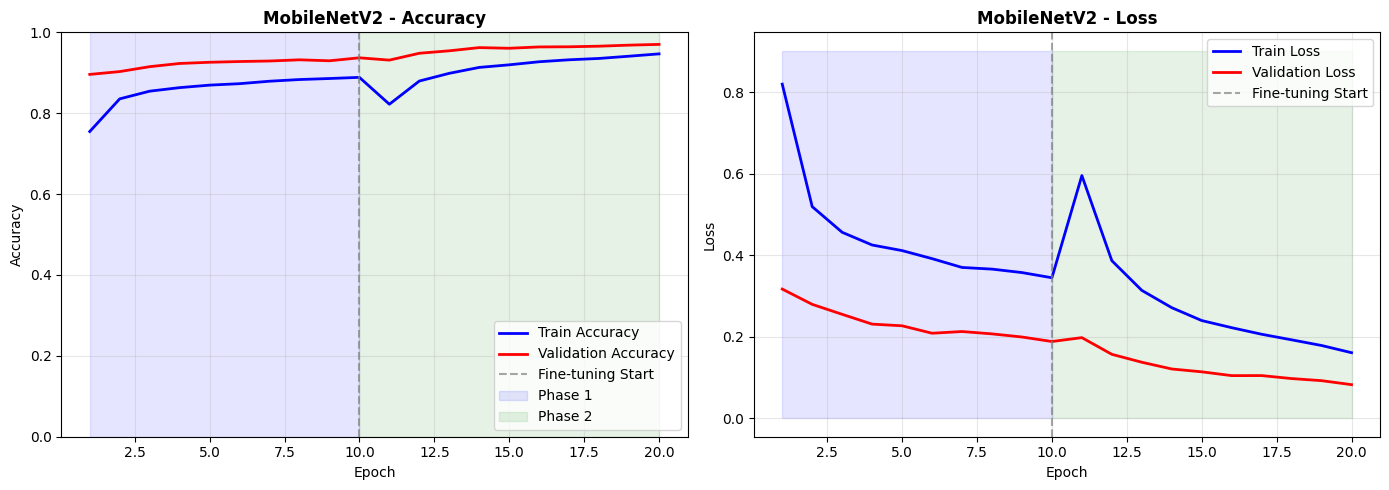


MobileNetV2 Training Statistics:
--------------------------------------------------
Phase 1 (Feature Extraction):
  Final Train Acc: 0.8886
  Final Val Acc: 0.9370
  Gap (overfitting indicator): -0.0484

Phase 2 (Fine-tuning):
  Best Train Acc: 0.9467
  Best Val Acc: 0.9702
  Final Train Acc: 0.9467
  Final Val Acc: 0.9702
  Gap (overfitting indicator): -0.0234


In [ ]:
# # Plot training history for MobileNetV2
plot_training_history(mobilenet_full_history, 'MobileNetV2', EPOCHS_PHASE1)


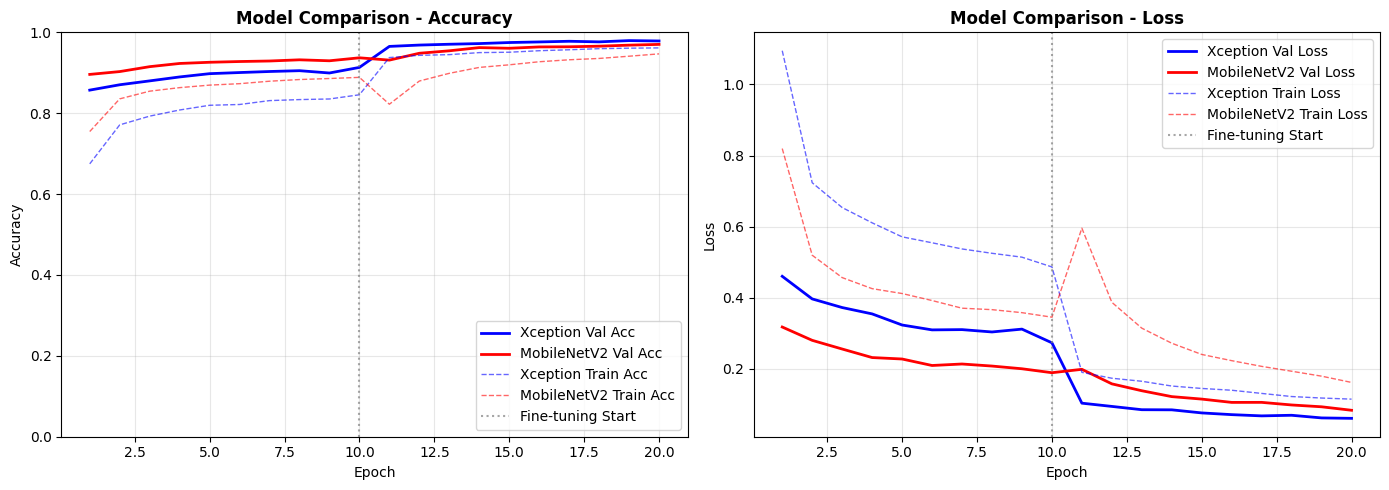

In [ ]:
# comparison of both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_xception = range(1, len(xception_full_history['accuracy']) + 1)
epochs_mobilenet = range(1, len(mobilenet_full_history['accuracy']) + 1)

# Validation Accuracy Comparison
axes[0].plot(epochs_xception, xception_full_history['val_accuracy'], 'b-', label='Xception Val Acc', linewidth=2)
axes[0].plot(epochs_mobilenet, mobilenet_full_history['val_accuracy'], 'r-', label='MobileNetV2 Val Acc', linewidth=2)
axes[0].plot(epochs_xception, xception_full_history['accuracy'], 'b--', label='Xception Train Acc', linewidth=1, alpha=0.6)
axes[0].plot(epochs_mobilenet, mobilenet_full_history['accuracy'], 'r--', label='MobileNetV2 Train Acc', linewidth=1, alpha=0.6)
axes[0].axvline(x=EPOCHS_PHASE1, color='gray', linestyle=':', alpha=0.7, label='Fine-tuning Start')
axes[0].set_title('Model Comparison - Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Validation Loss Comparison
axes[1].plot(epochs_xception, xception_full_history['val_loss'], 'b-', label='Xception Val Loss', linewidth=2)
axes[1].plot(epochs_mobilenet, mobilenet_full_history['val_loss'], 'r-', label='MobileNetV2 Val Loss', linewidth=2)
axes[1].plot(epochs_xception, xception_full_history['loss'], 'b--', label='Xception Train Loss', linewidth=1, alpha=0.6)
axes[1].plot(epochs_mobilenet, mobilenet_full_history['loss'], 'r--', label='MobileNetV2 Train Loss', linewidth=1, alpha=0.6)
axes[1].axvline(x=EPOCHS_PHASE1, color='gray', linestyle=':', alpha=0.7, label='Fine-tuning Start')
axes[1].set_title('Model Comparison - Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Model Evaluation on Test Set

Evaluating models on a test dataset that the model did not see during training.

In [ ]:
# Final evaluation on test set
print("=" * 60)
print("Final Evaluation on Test Set")
print("=" * 60)

# Xception evaluation
xception_test_results = xception_model.evaluate(test_gen, verbose=1)
print(f"\nXception Test Results:")
print(f"  Test Loss: {xception_test_results[0]:.4f}")
print(f"  Test Accuracy: {xception_test_results[1]:.4f}")

# MobileNetV2 evaluation
mobilenet_test_results = mobilenet_model.evaluate(test_gen, verbose=1)
print(f"\nMobileNetV2 Test Results:")
print(f"  Test Loss: {mobilenet_test_results[0]:.4f}")
print(f"  Test Accuracy: {mobilenet_test_results[1]:.4f}")


Final Evaluation on Test Set
170/170 ━━━━━━━━━━━━━━━━━━━━ 97s 573ms/step - accuracy: 0.9797 - loss: 0.0632

Xception Test Results:
  Test Loss: 0.0632
  Test Accuracy: 0.9797
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9663 - loss: 0.0979

MobileNetV2 Test Results:
  Test Loss: 0.0979
  Test Accuracy: 0.9663


In [ ]:
# comparison summary
comparison_data = {
    'Model': ['Xception', 'MobileNetV2'],
    'Total Parameters': [
        f"{xception_model.count_params():,}",
        f"{mobilenet_model.count_params():,}"
    ],
    'Best Val Accuracy': [
        f"{max(xception_full_history['val_accuracy']):.4f}",
        f"{max(mobilenet_full_history['val_accuracy']):.4f}"
    ],
    'Final Val Accuracy': [
        f"{xception_full_history['val_accuracy'][-1]:.4f}",
        f"{mobilenet_full_history['val_accuracy'][-1]:.4f}"
    ],
    'Test Accuracy': [
        f"{xception_test_results[1]:.4f}",
        f"{mobilenet_test_results[1]:.4f}"
    ],
    'Test Loss': [
        f"{xception_test_results[0]:.4f}",
        f"{mobilenet_test_results[0]:.4f}"
    ],
    'Train-Val Gap (Overfitting)': [
        f"{xception_full_history['accuracy'][-1] - xception_full_history['val_accuracy'][-1]:.4f}",
        f"{mobilenet_full_history['accuracy'][-1] - mobilenet_full_history['val_accuracy'][-1]:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)



MODEL COMPARISON SUMMARY
      Model Total Parameters Best Val Accuracy Final Val Accuracy Test Accuracy Test Loss Train-Val Gap (Overfitting)
   Xception       22,061,902            0.9796             0.9786        0.9797    0.0632                     -0.0171
MobileNetV2        3,062,118            0.9702             0.9702        0.9663    0.0979                     -0.0234


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# get predictions for test set
test_gen.reset()
xception_predictions = xception_model.predict(test_gen, verbose=1)
xception_pred_classes = np.argmax(xception_predictions, axis=1)

test_gen.reset()
mobilenet_predictions = mobilenet_model.predict(test_gen, verbose=1)
mobilenet_pred_classes = np.argmax(mobilenet_predictions, axis=1)

# True labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


170/170 ━━━━━━━━━━━━━━━━━━━━ 99s 582ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step


In [2]:
# Confusion Matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Xception Confusion Matrix
cm_xception = confusion_matrix(true_classes, xception_pred_classes)
im1 = axes[0].imshow(cm_xception, interpolation='nearest', cmap='Blues')
axes[0].set_title('Xception - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
plt.colorbar(im1, ax=axes[0])

# MobileNetV2 Confusion Matrix
cm_mobilenet = confusion_matrix(true_classes, mobilenet_pred_classes)
im2 = axes[1].imshow(cm_mobilenet, interpolation='nearest', cmap='Oranges')
axes[1].set_title('MobileNetV2 - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Classification Reports
print(f"\nXception: {np.sum(xception_pred_classes == true_classes)} correct out of {len(true_classes)} ({np.sum(xception_pred_classes == true_classes)/len(true_classes)*100:.2f}%)")
print(f"MobileNetV2: {np.sum(mobilenet_pred_classes == true_classes)} correct out of {len(true_classes)} ({np.sum(mobilenet_pred_classes == true_classes)/len(true_classes)*100:.2f}%)")


NameError: name 'plt' is not defined

In [ ]:
# Dynamic conclusions based on results
print("=" * 70)
print("AUTOMATIC RESULTS ANALYSIS")
print("=" * 70)

# Determine best model
xception_best_val = max(xception_full_history['val_accuracy'])
mobilenet_best_val = max(mobilenet_full_history['val_accuracy'])

winner = "Xception" if xception_test_results[1] > mobilenet_test_results[1] else "MobileNetV2"
print(f"\n BEST MODEL: {winner}")
print(f"   Test Accuracy: {max(xception_test_results[1], mobilenet_test_results[1]):.4f}")

# Overfitting analysis
print("\n📊 OVERFITTING ANALYSIS:")

xception_gap = xception_full_history['accuracy'][-1] - xception_full_history['val_accuracy'][-1]
mobilenet_gap = mobilenet_full_history['accuracy'][-1] - mobilenet_full_history['val_accuracy'][-1]

def analyze_overfitting(gap, model_name):
    if gap > 0.15:
        return f"   {model_name}: SEVERE OVERFITTING (gap={gap:.4f}). Recommendation: more dropout, data augmentation"
    elif gap > 0.05:
        return f"   {model_name}: MILD OVERFITTING (gap={gap:.4f}). Model is well balanced"
    else:
        return f"   {model_name}: EXCELLENT (gap={gap:.4f}). Model generalizes well"

print(analyze_overfitting(xception_gap, "Xception"))
print(analyze_overfitting(mobilenet_gap, "MobileNetV2"))

# Performance comparison
print("\n PERFORMANCE COMPARISON:")
print(f"   Xception parameters: {xception_model.count_params():,}")
print(f"   MobileNetV2 parameters: {mobilenet_model.count_params():,}")
print(f"   MobileNetV2 is {xception_model.count_params() / mobilenet_model.count_params():.1f}x smaller")

AUTOMATIC RESULTS ANALYSIS


NameError: name 'xception_full_history' is not defined